# Imports

In [1]:
import os

import numpy as np
from PIL import Image
from models.models import create_model
from SCDataset.SCDataset import SCDataLoader
from faceparsing.test import evaluate_image
from matplotlib import pyplot as plt

# Options

In [2]:
class Options:
    def __init__(self,
                 phase = "train",  # use test for inference
                 beta1 = 0.5,
                 beta2 = 0.999,
                 g_lr = 2e-4,
                 d_lr = 2e-4,
                 lambda_A = 10.0,
                 lambda_B = 10.0,
                 lambda_idt = 0.5,
                 lambda_his_lip=1.0,
                 lambda_his_skin=0.1,
                 lambda_his_eye=1.0,
                 lambda_vgg=5e-3,
                 num_epochs=100,
                 epochs_decay=0,
                 g_step=1,
                 log_step=8,
                 save_step=2048,
                 snapshot_path="./checkpoints/",
                 save_path="./results/",
                 snapshot_step=10,
                 perceptual_layers=3,
                 partial=False,
                 interpolation=False,
                 init_type="xavier",
                 dataroot="MT-Dataset/images",  # folder with 
                 dirmap="MT-Dataset/parsing",
                 batchSize=1,
                 input_nc=3,
                 img_size=256,
                 output_nc=3,
                 d_conv_dim=64,
                 d_repeat_num=3,
                 ngf=64,
                 gpu_ids="0",
                 nThreads=2,
                 norm1="SN",
                 serial_batches=True,
                 n_components=3,
                 n_res=3,
                 padding_type="reflect",
                 use_flip=0,
                 n_downsampling=2,
                 style_dim=192,
                 mlp_dim=256):
        self.phase = phase
        self.beta1 = beta1
        self.beta2 = beta2
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.lambda_A = lambda_A
        self.lambda_B = lambda_B
        self.lambda_idt = lambda_idt
        self.lambda_his_lip = lambda_his_lip
        self.lambda_his_skin = lambda_his_skin
        self.lambda_his_eye = lambda_his_eye
        self.lambda_vgg = lambda_vgg
        self.num_epochs = num_epochs
        self.epochs_decay = epochs_decay
        self.g_step = g_step
        self.log_step = log_step
        self.save_step = save_step
        self.snapshot_path = snapshot_path
        self.save_path = save_path
        self.snapshot_step = snapshot_step
        self.perceptual_layers = perceptual_layers
        self.partial = partial
        self.interpolation = interpolation

        self.init_type = init_type
        self.dataroot = dataroot
        self.dirmap = dirmap
        self.batchSize = batchSize
        self.input_nc = input_nc
        self.img_size = img_size
        self.output_nc = output_nc
        self.d_conv_dim = d_conv_dim
        self.d_repeat_num = d_repeat_num
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        self.nThreads = nThreads
        self.norm1 = norm1
        self.serial_batches = serial_batches
        self.n_components = n_components
        self.n_res = n_res
        self.padding_type = padding_type
        self.use_flip = use_flip
        self.n_downsampling = n_downsampling
        self.style_dim = style_dim
        self.mlp_dim = mlp_dim

# Utils

In [3]:
def handle_parsing(seg):
    """
    To match SCGAN segmentation
    """
    new = np.zeros_like(seg)
    new[seg == 0] = 0
    new[seg == 1] = 4
    new[seg == 2] = 7
    new[seg == 3] = 2
    new[seg == 4] = 6
    new[seg == 5] = 1
    new[seg == 6] = 0
    new[seg == 7] = 3
    new[seg == 8] = 5
    new[seg == 9] = 0
    new[seg == 10] = 8
    new[seg == 11] = 11
    new[seg == 12] = 9
    new[seg == 13] = 13
    new[seg == 14] = 10
    new[seg == 15] = 0
    new[seg == 16] = 0
    new[seg == 17] = 12
    return Image.fromarray(new)


def parsing(source_path, reference_path, checkpoint="79999_iter.pth", save=True):
    source_name = os.path.basename(source_path)
    reference_name = os.path.basename(reference_path)
    
    source_parent_dir = os.path.dirname(source_path)
    reference_parent_dir = os.path.dirname(reference_path)
    
    source_seg_dir = source_parent_dir + "/parsing"
    reference_seg_dir = reference_parent_dir + "/parsing"
    
    os.makedirs(source_seg_dir, exist_ok=True)
    os.makedirs(reference_seg_dir, exist_ok=True)
    
    source_seg = evaluate_image(source_path, cp=checkpoint)
    reference_seg = evaluate_image(reference_path, cp=checkpoint)
    
    new_source_seg = (f"{source_seg_dir}/{source_name}", handle_parsing(source_seg[1].astype(np.uint8)))
    new_reference_seg = (f"{reference_seg_dir}/{reference_name}", handle_parsing(reference_seg[1].astype(np.uint8)))
    
    new_source_seg[1].save(new_source_seg[0])
    new_reference_seg[1].save(new_reference_seg[0])
    
    return new_source_seg, new_reference_seg


def transfer(source_path, reference_path, opt, checkpoint="79999_iter.pth", save=True):
    source_seg, reference_seg = parsing(source_path, reference_path, checkpoint=checkpoint, save=save)
    
    # dataloader = SCDataLoader(opt)
    SCGan = create_model(opt, None)
    # SCGan.test()
    results = SCGan.transfer(source_path, reference_path, source_seg[0], reference_seg[0])
    
    fig, ax = plt.subplots(2, 3, figsize=(18, 12))

    ax[0][0].imshow(results[0])
    ax[0][0].set_title("Source")
    ax[0][1].imshow(results[1])
    ax[0][1].set_title("Reference")
    ax[0][2].imshow(results[2])
    ax[0][2].set_title("Transfer")

    ax[1][0].imshow(results[1])
    ax[1][0].set_title("Source")
    ax[1][1].imshow(results[0])
    ax[1][1].set_title("Reference")
    ax[1][2].imshow(results[3])
    ax[1][2].set_title("Removal")

    for a in ax[0]:
        a.axis("off")

    for a in ax[1]:
        a.axis("off")

    plt.show()
    
    return results

# Transfer

In [4]:
opt = Options(phase="test", dataroot="dataset2/images", dirmap="dataset2/parsing", save_path="results/")

loaded trained generator ./checkpoints/G.pth..!


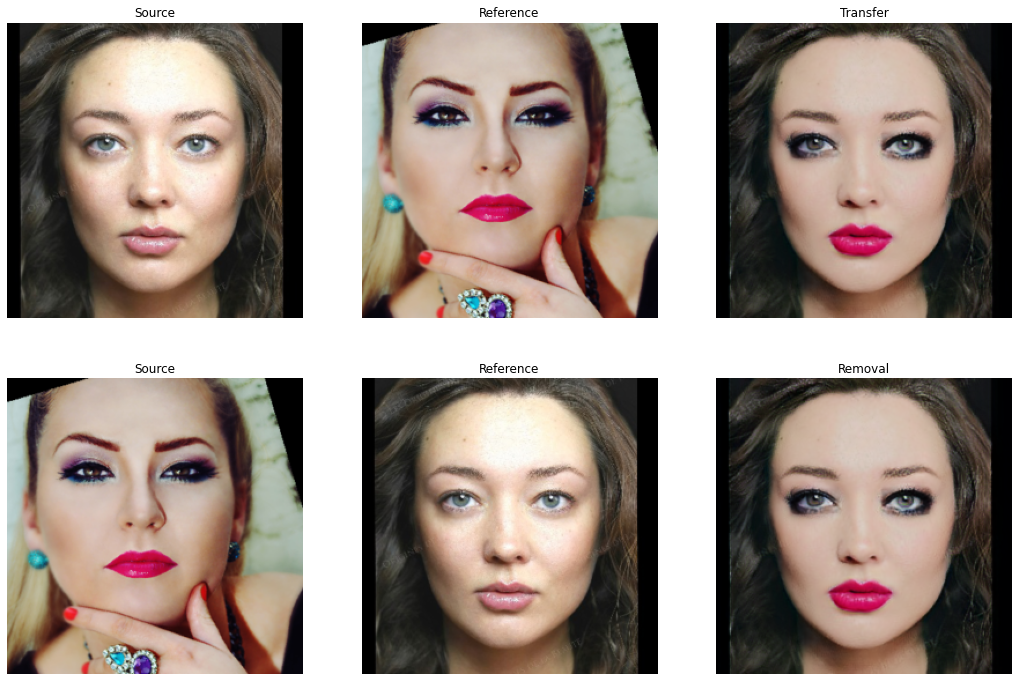

In [5]:
results = transfer("dataset/non-makeup/00313.jpg", "dataset/makeup/b7fd5266d01609248414333cdf0735fae6cd34e7.png", opt)

loaded trained generator ./checkpoints/G.pth..!


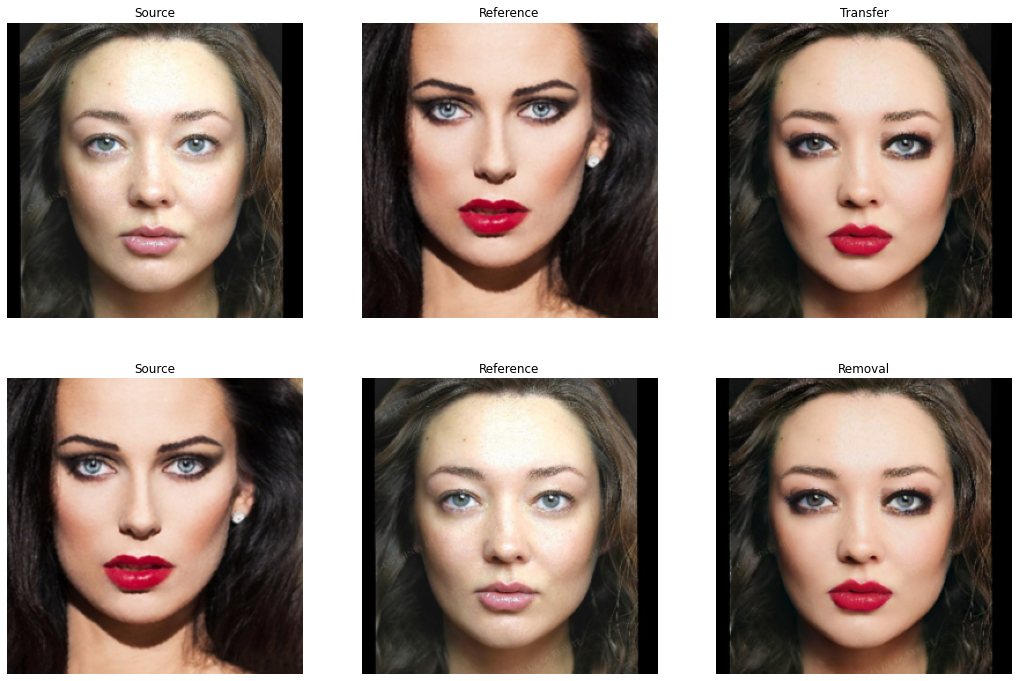

In [6]:
results = transfer("dataset/non-makeup/00313.jpg", "dataset/makeup/XMY-078.png", opt)